In [2]:
# load the training data
import os

imdb_dir = 'local_training_data/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')
labels = []
texts = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [4]:
# print out input data
print(len(labels))
print(len(texts))
print(labels[0])
print(texts[0])

25000
25000
0
Working with one of the best Shakespeare sources, this film manages to be creditable to it's source, whilst still appealing to a wider audience.<br /><br />Branagh steals the film from under Fishburne's nose, and there's a talented cast on good form.


In [5]:
# Tokenizing the text of the raw IMDB data
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import numpy as np

<class 'list'>


In [20]:
# cuts off reviews after 100 words
maxlen = 100
# Training 80%
training_samples = int(len(texts)*0.8)
# Considers only the top 10,000 words in the dataset
max_words = 10000

print(training_samples)

20000


In [ ]:
# tokenizer
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [6]:
print(type(sequences))
print(sequences[0])

<class 'list'>
[777, 16, 28, 4, 1, 115, 2278, 6887, 11, 19, 1025, 5, 27, 5, 42, 2425, 1861, 128, 2270, 5, 3, 6985, 308, 7, 7, 3383, 2373, 1, 19, 36, 463, 3169, 2, 222, 3, 1016, 174, 20, 49, 808]


In [7]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 88582 unique tokens.


In [8]:
data = pad_sequences(sequences, maxlen=maxlen)

<class 'numpy.ndarray'>


In [9]:
print(type(data))
print(data.shape)
print(data[0])

<class 'numpy.ndarray'>
(25000, 100)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0  777   16   28    4    1  115 2278 6887   11   19
 1025    5   27    5   42 2425 1861  128 2270    5    3 6985  308    7
    7 3383 2373    1   19   36  463 3169    2  222    3 1016  174   20
   49  808]


In [10]:
labels = np.asarray(labels)

In [12]:
print(labels.shape)
print(labels[0])

(25000,)
0


In [14]:
# shuffle the data
indices = np.arange(data.shape[0])
print(indices)
np.random.shuffle(indices)
print(indices)

[    0     1     2 ... 24997 24998 24999]
[14880 20862  8892 ... 16277 11753 18821]


In [15]:
# shuffle the data based on the indexes
data = data[indices]
labels = labels[indices]

In [16]:
print(data.shape)
print(data[0])

(25000, 100)
[  32  281 2325   24  327    2 6101   24  865  214   16  632    9   97
   25   74   98  294  148 5008   13   32  318 1097   85    4    1  585
  133   60  211  915   43   15  144  300    8    1   19    7    7  441
    3   52 1092   19  686    5    3 1331  226   16   46 7939    4   19
 1356 2992    1  113   13 1303   79   14 8166   66  318 1422   36 4343
    2 7800   34   13  569   49   26  253   24  170   40  205    2 1066
    1   84  739   13  937   42   54  591   42    3  386   19   36  377
    5 1361]


In [17]:
print(labels.shape)
print(labels[0])

(25000,)
1


In [21]:
# create training and validation set
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples:]
y_val = labels[training_samples:]

In [24]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(20000, 100)
(20000,)
(5000, 100)
(5000,)


In [25]:
# DOWNLOADING THE GLOVE WORD EMBEDDINGS
# Parsing the GloVe word-embeddings file
glove_dir = 'trained_models/glove.6B'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400001 word vectors.


In [32]:
# print out the dimension of embeddings
print(embeddings_index['the'].shape)

(100,)


In [27]:
# Build an embedding matrix that you can load into an Embedding layer
# It must be a matrix of shape (max_words, embedding_dim), where each entry i contains the embedding_dim-dimensional vector 
# for the word of index i in the reference word index
# Note that index 0 isn’t supposed to stand for any word or token—it’s a placeholder.
embedding_dim = 100 # see => embeddings_index['the'].shape
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [29]:
print(type(embedding_matrix))
print(embedding_matrix.shape)

<class 'numpy.ndarray'>
(10000, 100)


In [33]:
# Model definition
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# print out model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1000000   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 32)                320032    
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1320065 (5.04 MB)
Trainable params: 1320065 (5.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2023-10-12 16:28:04.605536: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-10-12 16:28:04.605645: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-10-12 16:28:04.605663: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-10-12 16:28:04.606159: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-12 16:28:04.606510: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [35]:
# Loading pretrained word embeddings into the Embedding layer
# Freeze the Embedding layer (set its trainable attribute to False)
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [36]:
# compile the model
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

In [37]:
# train the model
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Epoch 1/10


2023-10-12 16:30:15.623385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


623/625 [============================>.] - ETA: 0s - loss: 0.6747 - acc: 0.6273

2023-10-12 16:30:19.244700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - 5s 6ms/step - loss: 0.6748 - acc: 0.6272 - val_loss: 0.6066 - val_acc: 0.6730
Epoch 2/10
625/625 [==============================] - 4s 6ms/step - loss: 0.5405 - acc: 0.7284 - val_loss: 0.7994 - val_acc: 0.6102
Epoch 3/10
625/625 [==============================] - 4s 6ms/step - loss: 0.5025 - acc: 0.7606 - val_loss: 0.5609 - val_acc: 0.7250
Epoch 4/10
625/625 [==============================] - 4s 6ms/step - loss: 0.4717 - acc: 0.7798 - val_loss: 0.5685 - val_acc: 0.7238
Epoch 5/10
625/625 [==============================] - 4s 6ms/step - loss: 0.4509 - acc: 0.7927 - val_loss: 0.5825 - val_acc: 0.7250
Epoch 6/10
625/625 [==============================] - 4s 7ms/step - loss: 0.4348 - acc: 0.8036 - val_loss: 0.5924 - val_acc: 0.7312
Epoch 7/10
625/625 [==============================] - 4s 6ms/step - loss: 0.4125 - acc: 0.8170 - val_loss: 0.7258 - val_acc: 0.6850
Epoch 8/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3884 - acc:

In [38]:
# save the model weights
model.save_weights('trained_models/pre_trained_glove_model.h5')
# load the model weights
# model.load_weights('trained_models/pre_trained_glove_model.h5')

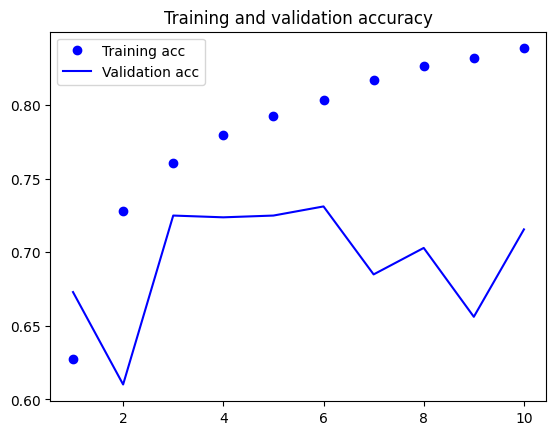

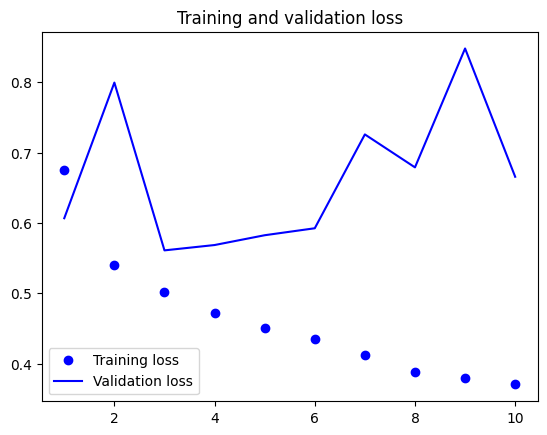

In [39]:
# Plotting the results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()